In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from skimage import feature
from sklearn import tree
from skimage import segmentation
from skimage import transform
from sklearn import neighbors
from skimage import measure
import h5py

In [19]:
file1 = h5py.File('Chiral_L_Large_HDF5_Original.h5')


/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [32]:
file2 = h5py.File('Chiral_D_Large_HDF5_Original.h5')


/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [7]:
def mask_img(img):
    i = transform.downscale_local_mean(img,(2,2))
    test = filters.gaussian(i)
    test = filters.gaussian(test)
    lp = filters.laplace(test)
    thresh1 = filters.threshold_otsu(test)
    mask1 = test>thresh1
    thresh2 = filters.threshold_otsu(lp)
    mask2 = lp>thresh2
    tot_mask = transform.rescale((mask1+mask2),2)
    test2 = img*tot_mask
    return test2


In [4]:
def rotate_stack(img_stack,mask_stack):
    rot_stack = np.zeros(img_stack.shape)
    for idx, mask in enumerate(mask_stack):
        label_img = label(mask)
        regions = regionprops(label_img)
        if len(regions) > 1:
            print('WARNING! Greater than 1 region detected in Image #',idx, 'number of regions: ', len(regions))
        orientation = regions[0].orientation*(180/np.pi)
        rot_stack[idx] = transform.rotate(img_stack[idx],-1*orientation,preserve_range=True)
    return rot_stack

In [5]:
def make_particle_stack(masked_imgs):
    particles = [ ]
    for img in masked_imgs:
        mask = img > 0
        label = measure.label(mask)
        regions = measure.regionprops(label)
        for reg in regions:
            part = np.zeros((128,128))
            r1,c1,r2,c2 = reg.bbox
            row = r2-r1
            col = c2-c1
            if row > 128 or col > 128:
                pass
            elif reg.area < 400:
                pass
            else:
                sub = img[r1:r2,c1:c2]
                part[64- int(np.floor(row/2)):64+int(np.ceil(row/2)),64-int(np.floor(col/2)):64+int(np.ceil(col/2))] = sub
                orientation = reg.orientation*(180/np.pi)
                particles.append(transform.rotate(part,-1*orientation,preserve_range=True))
    return np.array(particles)
        

In [6]:
def cut(img,cut_size):
    stack = []
    max_row = img.shape[0]
    max_col = img.shape[1]
    for i in np.arange(0,max_row-cut_size,cut_size):
        for j in np.arange(0,max_col-cut_size,cut_size):
            stack.append(img[i:i+cut_size,j:j+cut_size])
    return np.array(stack)

In [8]:
def particle_pipeline(large_img, cut_size):
    img_stack = cut(large_img,cut_size)
    mask_stack = [mask_img(img) for img in img_stack]
    particles = make_particle_stack(mask_stack)
    return particles

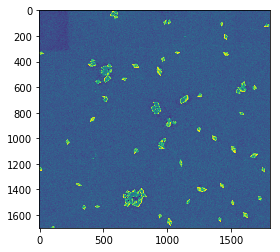

In [46]:
plt.imshow(file2['t0']['channel2'][300:2000,200:2000])

In [49]:
file2['t0']['channel2'].shape

(20126, 30970)

In [51]:
file2['t0']['channel2'][0,30969]

198

In [52]:
stack = []
for i in np.arange(300,20126-1024,1024):
    for j in np.arange(200,30970-1024,1024):
        stack.append(file2['t0']['channel2'][i:i+1024,j:j+1024])
stack = np.array(stack)

In [53]:
stack.shape

(570, 1024, 1024)

In [58]:
len(str(300))

3

In [60]:
for idx,img in enumerate(stack):
    if len(str(idx)) == 1:
        num = '00'+str(idx)
    elif len(str(idx)) == 2:
        num = '0' + str(idx)
    elif len(str(idx)) == 3:
        num = str(idx)
    filename = '/Users/cgroschner/Documents/Chiral_Nanoparticles/segmentation_labels/images/' + 'Chiral_D_20181031_img'+num+'.png'
    plt.imsave(filename,img,cmap='gray')

In [63]:
f = '/Users/cgroschner/Documents/Chiral_Nanoparticles/segmentation_labels/Chiral_D_20181031_stack.h5'
i = h5py.File(f,'w')
i.create_dataset('images',data=stack)
i.close()

In [34]:
particles = particle_pipeline(file2['t0']['channel2'][300:-500,200:-200],1000)


In [67]:
other_stack = h5py.File('chiral_image_stack.h5','r')['stack'][:,:,:]

In [68]:
other_stack.shape

(4096, 400, 400)

In [70]:
for idx,img in enumerate(other_stack[:200]):
    if len(str(idx)) == 1:
        num = '00'+str(idx)
    elif len(str(idx)) == 2:
        num = '0' + str(idx)
    elif len(str(idx)) == 3:
        num = str(idx)
    filename = '/Users/cgroschner/Documents/Chiral_Nanoparticles/segmentation_labels/images_20190205/' + 'Chiral_D_20190205_img'+num+'.png'
    plt.imsave(filename,img,cmap='gray')

In [2]:
from skimage import io

In [3]:
image = io.imread('Chiral_D_Large_TIFF_Cropped.tif')

In [4]:
stack = []
for i in np.arange(300,34416-10247,1024):
    for j in np.arange(200,54144-1024,1024):
        stack.append(image[i:i+1024,j:j+1024])
stack = np.array(stack)

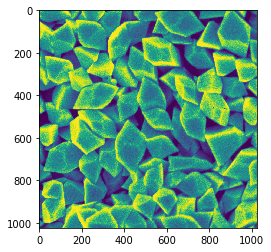

In [78]:
plt.imshow(stack[0])

In [79]:
for idx,img in enumerate(stack):
    if len(str(idx)) == 1:
        num = '00'+str(idx)
    elif len(str(idx)) == 2:
        num = '0' + str(idx)
    elif len(str(idx)) == 3:
        num = str(idx)
    filename = '/Users/cgroschner/Documents/Chiral_Nanoparticles/segmentation_labels/images_ChiralDLargeTIFF/' + 'ChiralDLargeTIFF_img'+num+'.png'
    plt.imsave(filename,img,cmap='gray')

In [2]:
from glob import glob

In [3]:
mask_files = glob('segmentation_labels/PixelLabelData_1/*')
img_files = glob('segmentation_labels/images_ChiralDLargeTIFF/*')[:11]

In [97]:
mask_files

['segmentation_labels/PixelLabelData_1/Label_01.png',
 'segmentation_labels/PixelLabelData_1/Label_02.png',
 'segmentation_labels/PixelLabelData_1/Label_03.png',
 'segmentation_labels/PixelLabelData_1/Label_04.png',
 'segmentation_labels/PixelLabelData_1/Label_05.png',
 'segmentation_labels/PixelLabelData_1/Label_06.png',
 'segmentation_labels/PixelLabelData_1/Label_07.png',
 'segmentation_labels/PixelLabelData_1/Label_08.png',
 'segmentation_labels/PixelLabelData_1/Label_09.png',
 'segmentation_labels/PixelLabelData_1/Label_10.png',
 'segmentation_labels/PixelLabelData_1/Label_11.png']

In [98]:
mask_stack = [io.imread(m,as_gray=True) for m in mask_files]

In [99]:
img_stack = [io.imread(i,as_gray=True) for i in img_files]

In [104]:
mask_stack[0].max()

255

In [106]:
mask_stack[0].min()

0

In [105]:
mask_stack[1].max()

1

In [107]:
mask_stack[0] = mask_stack[0]//255

In [108]:
mask_stack[0].max()

1

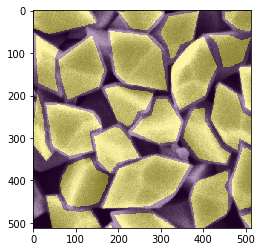

In [111]:
plt.imshow(img_stack[0][:512,:512],cmap='gray')
plt.imshow(mask_stack[0][:512,:512],alpha=0.4)

In [112]:
def slidding_window(image, mask, windowSize, step):
    numWindows = (image.shape[0]-windowSize)//step
    window_stack = []
    mask_stack = []
    for i in np.arange(0,numWindows):
        for j in np.arange(0,numWindows):
            window_stack.append(image[i*step:i*step+windowSize,j*step:j*step+windowSize])
            mask_stack.append(mask[i*step:i*step+windowSize,j*step:j*step+windowSize])
    window_stack = np.array(window_stack)
    mask_stack = np.array(mask_stack)
    return window_stack, mask_stack

In [115]:
for idx, img in enumerate(img_stack):
    sub_imstack, sub_mstack = slidding_window(img,mask_stack[idx],512,64)
    if idx == 0:
        new_mask_stack = sub_mstack
        new_img_stack = sub_imstack
    else:
        new_mask_stack = np.concatenate((new_mask_stack,sub_mstack),axis=0)
        new_img_stack = np.concatenate((new_img_stack,sub_imstack),axis=0)

In [116]:
new_img_stack.shape

(704, 512, 512)

In [117]:
new_mask_stack.shape

(704, 512, 512)

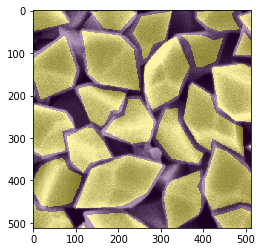

In [119]:
plt.imshow(new_img_stack[1],cmap='gray')
plt.imshow(new_mask_stack[1],alpha=0.4)

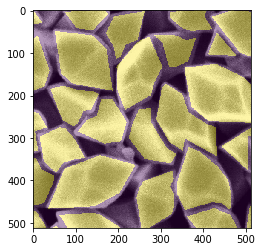

In [121]:
plt.imshow(new_img_stack[2],cmap='gray')
plt.imshow(new_mask_stack[2],alpha=0.4)

In [ ]:
def mask_particles(mask_stack,image_stack):
    particle

In [139]:
b = np.expand_dims(new_mask_stack[0],axis=2)
a = np.concatenate((b,np.abs(b-1)),axis=2)

In [140]:
a.shape

(512, 512, 2)

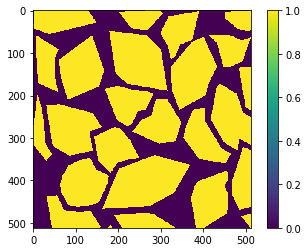

In [142]:
plt.imshow(a[:,:,0])
plt.colorbar()

In [144]:
new_mask_stack.shape

(704, 512, 512)

In [145]:
final_mask_stack = np.zeros((704,512,512,2))
for idx, m in enumerate(new_mask_stack):
    a = np.expand_dims(m,axis=2)
    b = np.abs(a-1)
    b = b/b.max()
    final_mask_stack[idx] = np.concatenate((a,b),axis=2)

In [146]:
final_mask_stack.shape

(704, 512, 512, 2)

In [147]:
i = h5py.File('chiralDLargeTiff_segmentation_20200930.h5')
i.create_dataset('images', data=np.expand_dims(new_img_stack,axis=3))
i.create_dataset('masks',data=final_mask_stack)
i.close()

/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [6]:
new_images = h5py.File('chiralDLargeTiff_segmentation_20200930.h5','r')['images'][:]
new_masks = h5py.File('chiralDLargeTiff_segmentation_20200930.h5','r')['masks'][:]

In [7]:
new_images.shape

(704, 512, 512, 1)

In [14]:
new_images.max()

1.0

In [20]:
from skimage import io
from skimage import transform

In [23]:
for idx,img in enumerate(new_images):
    if len(str(idx)) == 1:
        name = '00'+str(idx)
    elif len(str(idx)) == 2:
        name = '0'+str(idx)
    elif len(str(idx)) == 3:
        name = str(idx)
    fname = '/Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/images/img'+name+'.png' 
    io.imsave(fname,transform.rescale(img[:,:,0],0.5))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [27]:
import os

In [30]:
os.path.splitext(os.path.basename('/foo/bar/img.png'))

('img', '.png')

In [24]:
for idx,img in enumerate(new_masks):
    if len(str(idx)) == 1:
        name = '00'+str(idx)
    elif len(str(idx)) == 2:
        name = '0'+str(idx)
    elif len(str(idx)) == 3:
        name = str(idx)
    fname = '/Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/0/img'+name+'.png' 
    io.imsave(fname,transform.rescale(img[:,:,0],0.5))
    fname = '/Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/1/img'+name+'.png' 
    io.imsave(fname,transform.rescale(img[:,:,1],0.5))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/0/img645.png is a low contrast image
  if __name__ == '__main__':
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/1/img645.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/0/img646.png is a low contrast image
  if __n

/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/0/img656.png is a low contrast image
  if __name__ == '__main__':
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/1/img656.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/0/img657.png is a low contrast image
  if __n

/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/0/img667.png is a low contrast image
  if __name__ == '__main__':
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/1/img667.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/0/img668.png is a low contrast image
  if __n

/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/0/img678.png is a low contrast image
  if __name__ == '__main__':
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/1/img678.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/0/img679.png is a low contrast image
  if __n

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/0/img689.png is a low contrast image
  if __name__ == '__main__':
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/1/img689.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/0/img700.png is a low contrast image
  if __name__ == '__main__':
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: /Users/cgroschner/Documents/Chiral_Nanoparticles/pytorch-nested-unet/inputs/chiral_np/masks/1/img700.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: /Users/cgroschner/

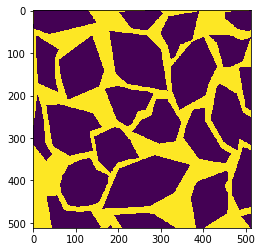

In [12]:
plt.imshow(new_masks[0,:,:,1])

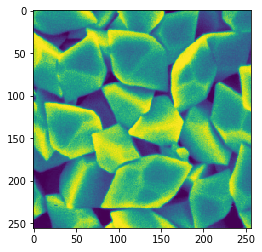

In [21]:
plt.imshow(transform.rescale(new_images[0,:,:,0],0.5))

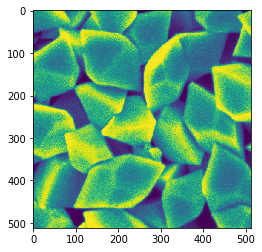

In [9]:
plt.imshow(new_images[1,:,:,0])

In [149]:
704*0.6

422.4

In [150]:
704*0.2

140.8

In [151]:
422+141

563

In [152]:
704-563

141

In [74]:
image.shape

(34416, 54144)

In [75]:
m = mask_img(image[:512,:512])

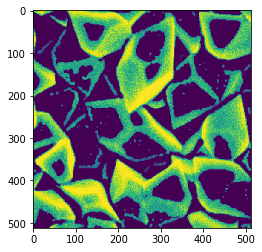

In [76]:
plt.imshow(m)

In [35]:
len(particles)


10314

In [37]:
%matplotlib inline

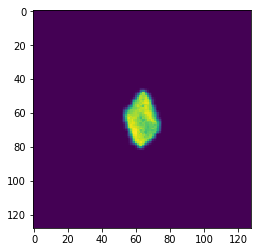

In [44]:
plt.imshow(particles[57])


In [9]:
particles2 = particle_pipeline(file2['t0']['channel2'][300:-500,200:-200],1000)

In [10]:
len(particles2)

10314

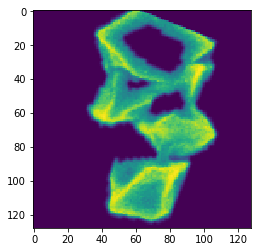

In [26]:
plt.imshow(particles2[10000])

In [27]:
from PIL import Image
import ipywidgets as widgets
from ipywidgets import interact, interactive
from pigeon import annotate
from IPython.display import display, Image
import pickle

In [30]:
%matplotlib notebook

In [31]:
annotations = annotate(
  particles2,
  options=['left', 'right', 'garbage'],
  display_fn=lambda filename: plt.imshow(filename,cmap='gray'))

HTML(value='0 examples annotated, 10315 examples left')

Output()

## Other stuff

In [247]:
np.sum(particles[0]>0)

2870

In [71]:
cords = feature.corner_peaks(feature.corner_harris(test2), min_distance=2)

In [79]:
cords.shape

(10, 2)

In [74]:
tre = neighbors.KDTree(cords, leaf_size=2)

In [113]:
nn = tre.query_radius(cords, r=24, return_distance=True)

In [104]:
nn[0].shape

(10,)

In [99]:
nn[1].shape

(10,)

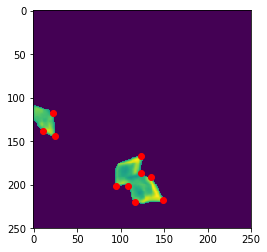

In [84]:
plt.imshow(test2)
plt.scatter(cords[:,1],cords[:,0],color='r')

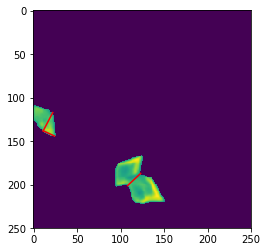

In [116]:
plt.imshow(test2)
plt.plot(cords[:2,1],cords[:2,0],color='r')
# plt.plot([cords[0,1],cords[2,1]],[cords[0,0],cords[2,0]],color='r')
plt.plot([cords[1,1],cords[2,1]],[cords[1,0],cords[2,0]],color='r')
plt.plot([cords[4,1],cords[7,1]],[cords[4,0],cords[7,0]],color='r')

In [95]:
cords[:1,1]

array([22])

In [114]:
nn[0]

array([array([0, 1]), array([0, 1, 2]), array([1, 2]), array([3, 4]),
       array([7, 3, 4, 5]), array([4, 5]), array([6, 7]),
       array([6, 7, 4, 9]), array([8]), array([7, 9])], dtype=object)

In [86]:
nn[1]

array([array([ 0.        , 23.70653918, 27.07397274]),
       array([23.70653918,  0.        , 14.31782106]),
       array([27.07397274, 14.31782106,  0.        ]),
       array([ 0.        , 20.02498439, 26.40075756]),
       array([31.30495168, 20.51828453, 20.02498439,  0.        , 12.64911064,
       33.54101966]),
       array([28.7923601 , 26.40075756, 12.64911064,  0.        , 30.41381265,
       34.13209633]),
       array([ 0.        , 13.        , 31.30495168, 29.06888371]),
       array([13.        ,  0.        , 20.51828453, 28.7923601 , 21.02379604]),
       array([30.41381265,  0.        , 32.06243908]),
       array([29.06888371, 21.02379604, 33.54101966, 34.13209633, 32.06243908,
        0.        ])], dtype=object)

In [87]:
cords

array([[117,  22],
       [138,  11],
       [144,  24],
       [167, 124],
       [187, 123],
       [191, 135],
       [201,  95],
       [201, 108],
       [218, 149],
       [220, 117]])

In [91]:
cords.shape[:-1]

(10,)

In [ ]:
line_pairs = 